# Анализ результативности футбольных команд

Команда «Е.Д.А.»
 - Максимов Дмитрий Николаевич
 - Никитина Елизавета Андреевна
 - Соловьев Александр Сергеевич 

## Шаг 1. Тема и общее описание проекта

В футболе существует огромное количество статистики по итогам матчей — количество пасов/навесов, xG (Expected Goals), доля ударов в створ и многое другое. Наша команда заинтересовалась, можно ли по этой статистике оценивать результативность футбольной команды и, соответственно, пытаться предсказывать исход матчей.

Для этого мы решили взглянуть на последние несколько сезонов Английской Премьер лиги и поставили задачу предугадать чемпиона текущего сезона. В качестве основного источника данных мы взяли сайт https://fbref.com/en/, так как он предоставляет большое количество статистики

## Шаг 2. Сбор данных

### Как мы собирали данные?
Fbref имеет некоторые ограничения для сбора данных — слишком частые запросы (больше 20 в минуту) блокируются, поэтому в одной из версий парсера мы решили расставить паузы так, чтобы не нарушать это требование со стороны fbref. В итоге необходимые данные мы скачали за примерно 1.5 часа. 
Код парсера можно посмотреть [здесь](https://github.com/asolovyov03/soccer-analysis/blob/main/scripts/parse.py)

Итоговые данные мы сохранили в файл [match_stats.json](https://github.com/asolovyov03/soccer-analysis/blob/main/match_stats.json)

### Какие данные мы собрали?
Мы решили взять статистику всех матчей АПЛ с сезона 2018-2019 по текущий (последний матч на момент парсинга прошёл 8 мая)
Для домашней и гостевой команды мы собрали следующие признаки:
- **team**: название команды
- **score**: количество голов, которая команда забила по итогам матча
- **xG**: показатель Expected Goals (расчитана аналитической компанией Opta)
- **possession**: доля владения мячом
- **passing_accuracy**: точность пасов (доля успешных пасов)
- **shots_on_target**: доля ударов в створ
- **yellow_cards_count**: количество желтых карточек
- **red_cards_count**: количество красных карточек
- **fouls**: количество совершенных фолов
- **corners**: количество угловых
- **crosses**: количество навесов
- **touches**: количество касаний мяча
- **tackles**: количество перехватов
- **interceptions**: количество отборов мяча
- **aerials_won**: количество выигрышей мяча в воздухе
- **clearances**: количество выбитых мячей
- **offsides**: количетсво попаданий в оффсайд
- **goal_kicks**: количество ударов от ворот
- **throw_ins**: количество вбросов в игру
- **long_balls**: количество дальних передач
- **match_date**: дата матча
- **match_week**: номер недели чемпионата

## Шаг 3. Предварительная обработка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import statsmodels.api as sm
import datetime

from statsmodels.formula.api import ols
from scipy.stats import ttest_ind, pearsonr

In [14]:
with open("match_stats.json") as file:
    matches = json.loads(file.read())
stat_keys = matches[0]['home'].keys()
data = {}
data.update({'home_' + k: [] for k in stat_keys})
data.update({'guest_' + k: [] for k in stat_keys})

for match in matches:
    for key in stat_keys:
        if key not in match['home']:
            data['home_' + key].append(None)
        else:
            data['home_' + key].append(match['home'][key])
    for key in stat_keys:
        if key not in match['guest']:
            data['guest_' + key].append(None)
        else:
            data['guest_' + key].append(match['guest'][key])

df = pd.DataFrame(data)
df.dropna(inplace=True)

Взгляним на то, что из себя представляет полученный df

In [15]:
df.head()

,home_team,home_score,home_xG,home_possession,home_passing_accuracy,home_shots_on_target,home_yellow_cards_count,home_red_cards_count,home_fouls,home_corners,...,guest_crosses,guest_touches,guest_tackles,guest_interceptions,guest_aerials_won,guest_clearances,guest_offsides,guest_goal_kicks,guest_throw_ins,guest_long_balls
0,Crystal Palace,0,1.2,0.56,0.84,0.20,1,0,16,3.0,...,11,599.0,29.0,9,14.0,24.0,2.0,2.0,14.0,59.0
1,Fulham,2,1.2,0.33,0.60,0.25,2,0,7,4.0,...,18,784.0,11.0,10,13.0,16.0,4.0,5.0,35.0,94.0
2,Tottenham Hotspur,4,1.5,0.58,0.83,0.44,3,0,11,10.0,...,18,554.0,14.0,13,11.0,21.0,0.0,4.0,14.0,61.0
3,Newcastle United,2,1.7,0.61,0.79,0.39,0,0,9,11.0,...,9,475.0,15.0,10,16.0,37.0,0.0,12.0,26.0,70.0
4,Leeds United,2,0.8,0.40,0.74,0.33,2,0,13,6.0,...,20,720.0,16.0,14,7.0,17.0,1.0,9.0,23.0,72.0


Посчитаем основные статистики для наших признаков

In [16]:
df.describe()

,home_score,home_xG,home_possession,home_passing_accuracy,home_shots_on_target,home_yellow_cards_count,home_red_cards_count,home_fouls,home_corners,home_crosses,...,guest_crosses,guest_touches,guest_tackles,guest_interceptions,guest_aerials_won,guest_clearances,guest_offsides,guest_goal_kicks,guest_throw_ins,guest_long_balls
count,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,...,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000
mean,1.509485,1.452755,0.510768,0.766942,0.332335,1.594851,0.032520,10.445348,5.665312,19.883017,...,16.410117,604.386179,16.542005,10.599368,17.135050,23.850949,1.749774,7.952123,20.438573,70.181120
std,1.327062,0.822777,0.126965,0.075234,0.154530,1.254649,0.184901,3.383120,3.050931,8.397402,...,7.424682,133.841303,5.205562,4.266942,7.144579,10.722453,1.526298,3.484581,6.161303,14.216618
min,0.000000,0.000000,0.180000,0.490000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,299.000000,3.000000,0.000000,1.000000,1.000000,0.000000,0.000000,3.000000,30.000000
25%,1.000000,0.800000,0.420000,0.720000,0.220000,1.000000,0.000000,8.000000,3.000000,14.000000,...,11.000000,503.000000,13.000000,7.000000,12.000000,16.000000,1.000000,5.000000,16.000000,60.000000
50%,1.000000,1.300000,0.510000,0.780000,0.330000,1.000000,0.000000,10.000000,5.000000,19.000000,...,16.000000,591.500000,16.000000,10.000000,16.000000,22.000000,1.000000,8.000000,20.000000,69.000000
75%,2.000000,2.000000,0.610000,0.820000,0.430000,2.000000,0.000000,13.000000,8.000000,25.000000,...,21.000000,690.750000,20.000000,13.000000,21.000000,30.000000,3.000000,10.000000,24.000000,79.750000
max,9.000000,5.900000,0.820000,0.920000,1.000000,7.000000,2.000000,23.000000,18.000000,64.000000,...,53.000000,1089.000000,46.000000,29.000000,52.000000,80.000000,10.000000,23.000000,44.000000,127.000000


Проверим, есть ли пропуски в данных

In [17]:
df.isna().any().any()

False

Пропуски отсутствуют

In [18]:
df_calendar = pd.read_table('file.tsv',sep=',')
df_calendar['Месяц'] = df_calendar['Дата'].apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y').strftime('%m'))
df_calendar['Месяц'] = df_calendar['Месяц'].astype(int)
df_calendar.head()

,Домашняя команда,Гостевая команда,Дата,Стадион,Город,home_score,guest_score,Месяц
0,Кристал,Пэлас,05.08.2022,Селхерст Парк,Лондон,0,2,8
1,Фулхэм,Ливерпуль,06.08.2022,Крэйвен Коттедж,Лондон,2,2,8
2,Борнмут,Астон,06.08.2022,Виталити - Дин Корт,Борнмут,2,0,8
3,Лидс,Юнайтед,06.08.2022,Элланд Роуд,Лидс,2,1,8
4,Ньюкасл,Юнайтед,06.08.2022,Сент-Джеймс Парк,Ньюкасл-апон-Тайн,2,0,8


In [19]:
df_weather = pd.read_table('weather.tsv')
df_weather.loc[(df_weather['Город'] =='Брэдфорд'), 'Город'] = 'Брентфорд'
df_weather.loc[(df_weather['Город'] =='Уольверхэмптон'), 'Город'] = 'Вулверхэмптон'
df_weather.loc[(df_weather['Город'] =='Брайтон'), 'Город'] = 'Брайтон энд Хоув'
df_weather.head()

,Город,Месяц,Название месяца,Дневная температура,Дождь,Осадки
0,Борнмут,1,Январь,+10°C,7,(89.5мм)
1,Борнмут,2,Февраль,+10.8°C,6,(65.4мм)
2,Борнмут,3,Март,+11.5°C,3,(33.0мм)
3,Борнмут,4,Апрель,+13°C,5,(50.8мм)
4,Борнмут,5,Май,+15.5°C,6,(48.5мм)


In [20]:
data = pd.merge(df_calendar, df_weather, on = ['Месяц', 'Город'])
data['Дневная температура'] = data['Дневная температура'].str.replace('°C', '')
data['Осадки'] = data['Осадки'].str.replace('мм)', '').str.replace('(', '')
data.head()

,Домашняя команда,Гостевая команда,Дата,Стадион,Город,home_score,guest_score,Месяц,Название месяца,Дневная температура,Дождь,Осадки
0,Кристал,Пэлас,05.08.2022,Селхерст Парк,Лондон,0,2,8,Август,+21.5,3,51.1
1,Фулхэм,Ливерпуль,06.08.2022,Крэйвен Коттедж,Лондон,2,2,8,Август,+21.5,3,51.1
2,Тоттенхэм,Хотспур,06.08.2022,Тоттенхэм Хотспур,Лондон,4,1,8,Август,+21.5,3,51.1
3,Вест,Хэм,07.08.2022,Олимпийский,Лондон,0,2,8,Август,+21.5,3,51.1
4,Арсенал,Лестер,13.08.2022,Эмирейтс - Эшбертон Гроув,Лондон,4,2,8,Август,+21.5,3,51.1


In [21]:
data.isna().any().any()

False

Пропуски отсутствуют

## Шаг 4. Визуализация

Попробуем посмотреть, есть ли некоторые ожидаемые закономерности в наших данных, с помощью визуализации

Сравним количество забитых голов дома и в гостях (принято считать, что в гостях играть сложнее)

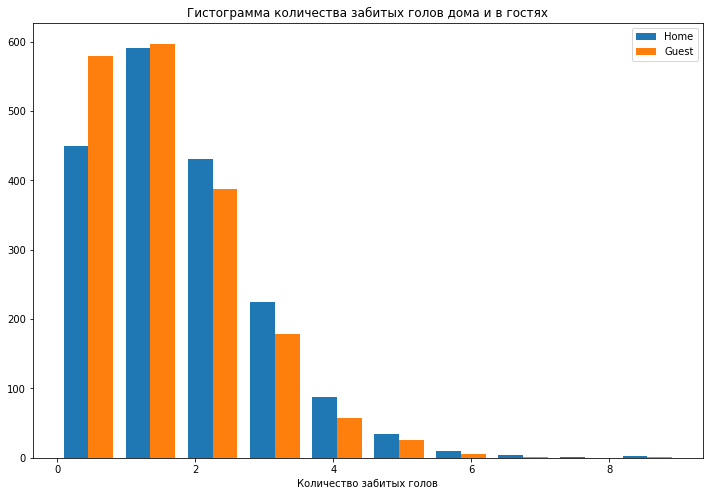

In [6]:
plt.figure(figsize=(12,8))
plt.hist([df['home_score'], df['guest_score']], label=['Home', 'Guest'])
plt.title("Гистограмма количества забитых голов дома и в гостях")
plt.xlabel("Количество забитых голов")
plt.legend();

Заметно, что у распределения голов гостей более тяжелый левый хвост. Они чаще не забивают вовсе или ограничиваются одним голом, хозяева же чаще результативнее. Можно предположить, что это связано со тактикой команды — в гостях больше защищаемся и менее активно атакуем. Давайте попробуем это проверить

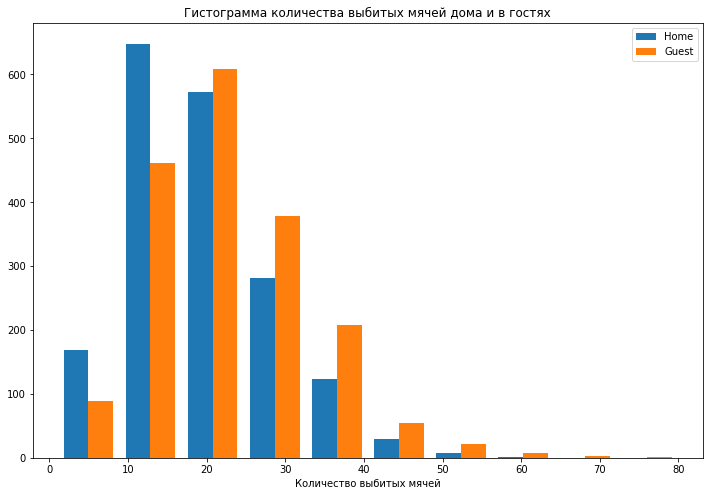

In [7]:
plt.figure(figsize=(12,8))
plt.hist([df['home_clearances'], df['guest_clearances']], label = ['Home', 'Guest'])
plt.title("Гистограмма количества выбитых мячей дома и в гостях")
plt.xlabel("Количество выбитых мячей")
plt.legend();

Видно, что гости заметно чаще выбивают мяч, посмотрим другие показатели игры от защиты

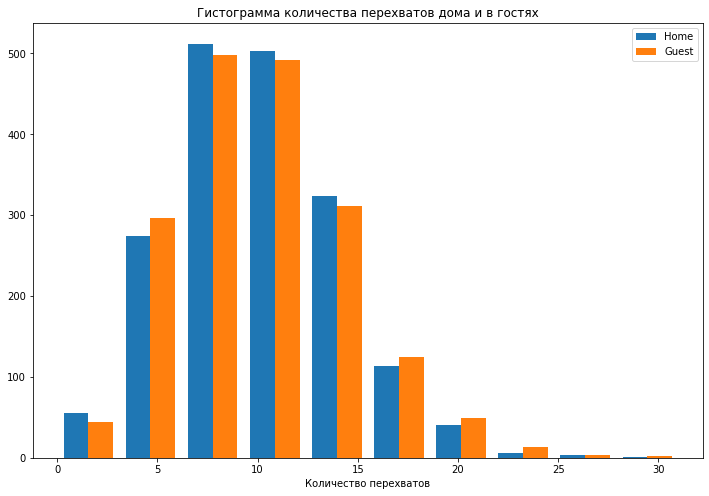

In [8]:
plt.figure(figsize=(12, 8))
plt.hist([df['home_interceptions'], df['guest_interceptions']], label=['Home', 'Guest'])
plt.title("Гистограмма количества перехватов дома и в гостях")
plt.xlabel("Количество перехватов")
plt.legend();

А в количестве отборов различий нет. Интересно! Давайте посмотрим на корреляцию между показателями, связанными с игрой в защите и возможно найдем что-то интересное

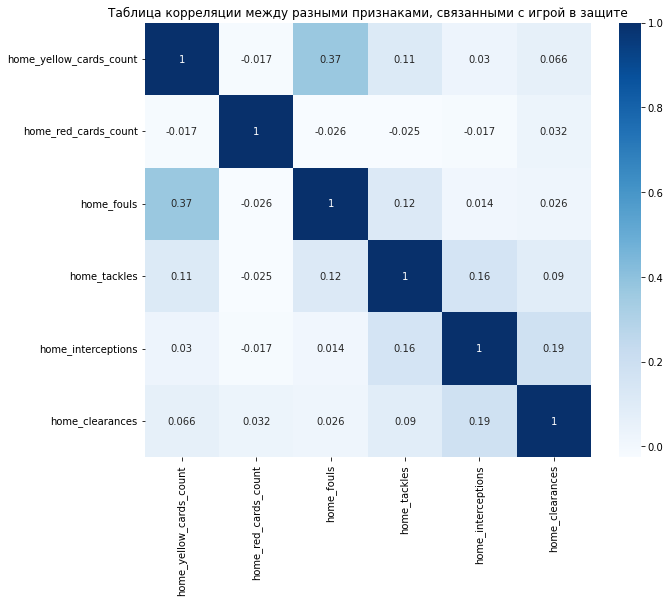

In [9]:
defensive_parametrs = ['home_yellow_cards_count', 'home_red_cards_count', 'home_fouls', 'home_tackles', 'home_interceptions', 'home_clearances']
plt.figure(figsize=(10, 8))
plt.title("Таблица корреляции между разными признаками, связанными с игрой в защите")
sns.heatmap(data=df[defensive_parametrs].corr(), annot=True, cmap='Blues');

Как заметно, почти везде корреляция достаточно слабая (кроме желтых карточек и фолов, что довольно очевидно). Об отсутствии зависимости говорить рано (вполне возможно она нелинейная), но это точно вопрос для дальнейшего изучения

Возможно низкая корреляция связана с тем, что каждый из этих показателей по-разному говорят об эффективности игры в защите. Например, перехват мяча позволяет дальше развить атаку, а выбивание его скорее говорит о неэффективности команды. Давайте сравним несколько показателей с количеством пропущенных и забитых голов

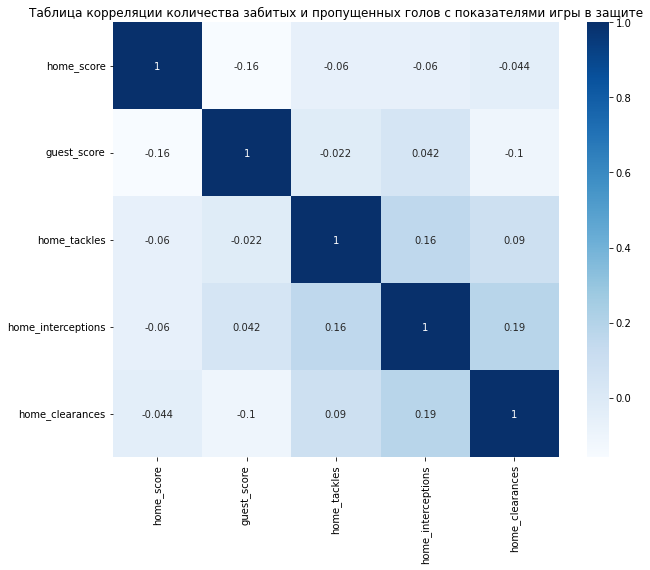

In [10]:
params = ['home_score', 'guest_score', 'home_tackles', 'home_interceptions', 'home_clearances']
plt.figure(figsize=(10, 8))
plt.title("Таблица корреляции количества забитых и пропущенных голов с показателями игры в защите")
sns.heatmap(data=df[params].corr(), annot=True, cmap='Blues');

Пока зависимостей в вопросах защиты особо не видно, оставим их поиск на более поздний этап

Посмотрим лучше на показатели атаки

Создадим df с основными показателями и количеством голов домашней команды и взгляним на него

In [11]:
df_home_score=df[['home_score','home_goal_kicks','home_passing_accuracy','home_possession']]
df_home_score.head()

,home_score,home_goal_kicks,home_passing_accuracy,home_possession
0,0,4,0.84,0.56
1,2,8,0.60,0.33
2,4,5,0.83,0.58
3,2,2,0.79,0.61
4,2,9,0.74,0.40


Попробуем найти закономерности. Для этого построим pairplot

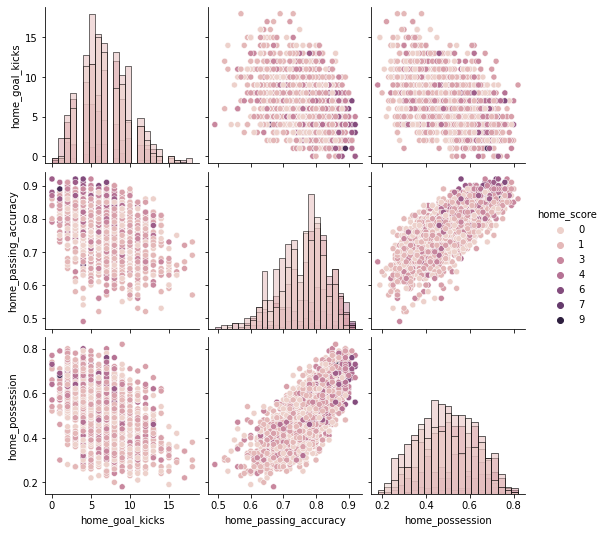

In [12]:
sns.pairplot(df_home_score,hue='home_score',diag_kind="hist");

Видна заметная зависимость между точностью пасов и владением мяча. Также заметно, что большое количество голов забивают команды с высоким значением владения мяча 

Посмотрим, есть ли отличия в данных зависимостях у гостевой команды

In [13]:
df_guest_score=df[['guest_score','guest_goal_kicks','guest_passing_accuracy','guest_possession']]
df_guest_score.head()

,guest_score,guest_goal_kicks,guest_passing_accuracy,guest_possession
0,2,2,0.81,0.44
1,2,5,0.76,0.67
2,1,4,0.79,0.42
3,0,12,0.71,0.39
4,1,9,0.84,0.60


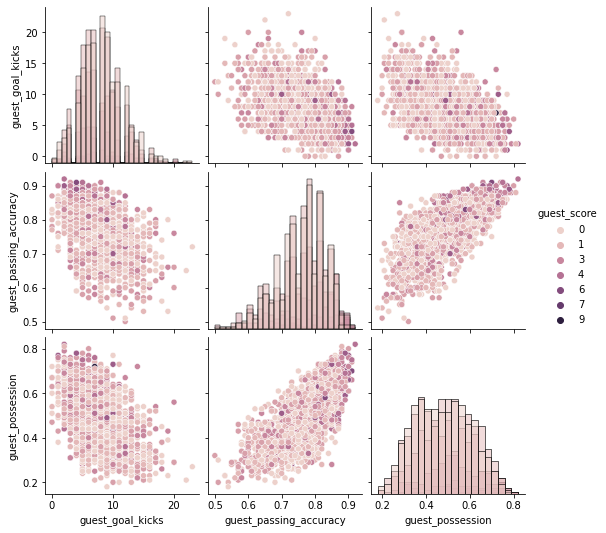

In [14]:
sns.pairplot(df_guest_score,hue='guest_score',diag_kind="hist");

Больших отличий не заметно

Теперь попробуем найти закономерности с ростом игроков. Для этого мы спарсили данные ([код парсера](https://github.com/asolovyov03/soccer-analysis/blob/main/scripts/Players_parser.py)) с сайта АПЛ и посчитаем средний рост для команд-участников чемпионата. Данные собраны в файле [information.tsv](https://github.com/asolovyov03/soccer-analysis/blob/main/information.tsv)

In [23]:
columns = ['Команда','Игрок','Позиция','Рост']
df_players = pd.read_table('information.tsv',sep=',', header=None,names=columns,skiprows=1)
df_players=df_players.iloc [1: , :]
df_players.loc[(df_players['Команда'] =='AFC Bournemouth'), 'Команда'] ='Bournemouth'
df_players.loc[(df_players['Команда'] =='Brighton and Hove Albion'), 'Команда'] ='Brighton & Hove Albion'
df_players.head()

,Команда,Игрок,Позиция,Рост
1,Manchester United,David de Gea,Goalkeeper,192cm
2,Manchester United,Tom Heaton,Goalkeeper,188cm
3,Manchester United,Tom Heaton,Goalkeeper,188cm
4,Manchester United,Nathan Bishop,Goalkeeper,185cm
5,Manchester United,Jack Butland,Goalkeeper,196cm


In [24]:
df_players["Рост"] = df_players["Рост"].str.replace(r"[^\d\.]", "", regex=True)
df_players["Рост"] = df_players["Рост"].astype (int)
df_players['Рост_м'] = (df_players['Рост'])/100
df_players.head()

,Команда,Игрок,Позиция,Рост,Рост_м
1,Manchester United,David de Gea,Goalkeeper,192,1.92
2,Manchester United,Tom Heaton,Goalkeeper,188,1.88
3,Manchester United,Tom Heaton,Goalkeeper,188,1.88
4,Manchester United,Nathan Bishop,Goalkeeper,185,1.85
5,Manchester United,Jack Butland,Goalkeeper,196,1.96


Добавим понижающий вес для вратаря — его высокий рост редко помогает команде забивать голы, так что не будем на нём сейчас сосредотачиваться

In [25]:
def assign_value(self):
    if str(self['Позиция']) =='Goalkeeper':
        return '0.5'
    else:
        return '1'

In [26]:
df_players['Веса'] = df_players.apply(assign_value, axis=1)
df_players.head()

,Команда,Игрок,Позиция,Рост,Рост_м,Веса
1,Manchester United,David de Gea,Goalkeeper,192,1.92,0.5
2,Manchester United,Tom Heaton,Goalkeeper,188,1.88,0.5
3,Manchester United,Tom Heaton,Goalkeeper,188,1.88,0.5
4,Manchester United,Nathan Bishop,Goalkeeper,185,1.85,0.5
5,Manchester United,Jack Butland,Goalkeeper,196,1.96,0.5


In [27]:
df_players["Веса"] = df_players["Веса"].astype (float) #добавляем веса, уменьшая вес для вратаря, чтобы далее проверить корреляцию с угловыми
mean_height = df_players.groupby('Команда').agg({'Рост': lambda x: np.average(x, weights=df_players.loc[x.index, 'Веса'])})
mean_height.head()

,Рост
Команда,
Arsenal,179.838235
Aston Villa,182.056604
Bournemouth,181.691176
Brentford,180.967213
Brighton & Hove Albion,179.322034


In [28]:
teams=mean_height.index.tolist() # создаем лист с командами для группировки

In [29]:
data=[]
for team in teams:
    corners=0
    goals=0
    tries=0
    for i in range(len(df)):
        if df['home_team'][i]==team:
            corners+=df['home_corners'][i].astype(int)
            tries+=df['home_goal_kicks'][i].astype(int)
            goals+=df['home_score'][i].astype(int)
        if df['guest_team'][i]==team:
            corners+=df['guest_corners'][i].astype(int)
            tries+=df['guest_goal_kicks'][i].astype(int)
            goals+=df['guest_score'][i].astype(int)
    data.append({'Команда': team, 'Угловые': corners,'Удары по воротам':tries,'Забито':goals})
merged=pd.DataFrame(data)
merged=merged.set_index('Команда')
merged_df = pd.merge(merged, mean_height, on='Команда', how='outer')
merged_df.head()

,Угловые,Удары по воротам,Забито,Рост
Команда,,,,
Arsenal,1274,1435,401,179.838235
Aston Villa,737,1104,192,182.056604
Bournemouth,726,1236,172,181.691176
Brentford,299,529,96,180.967213
Brighton & Hove Albion,1102,1602,244,179.322034


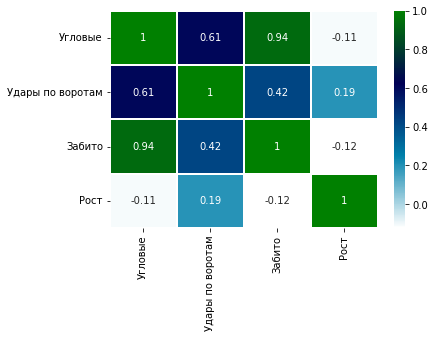

In [22]:
sns.heatmap(
    merged_df.corr(),
    annot=True,
    cmap='ocean_r',
    linewidths=0.1
);

Рост слабо коррелирует с другими показателями, зато видно интересные закономерности — количество угловых очень сильно коррелирует с количеством голов

Построим pairplot, чтобы визуально посмотреть, есть ли нелинейные зависимости 

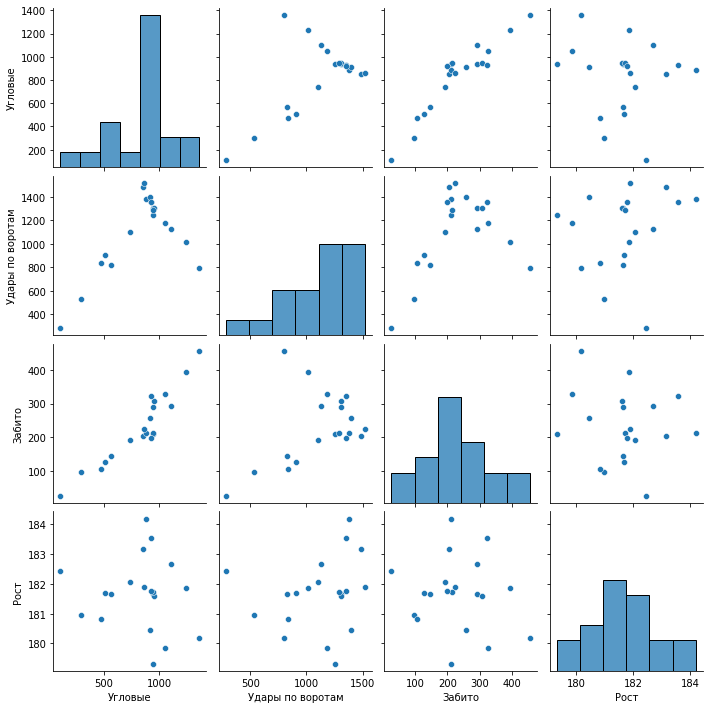

In [23]:
sns.pairplot(merged_df);

К сожалению, в наших данных нет показателя количества голов, забитых с углового, но попробуем воссоздать что-то похожее синтетически. Посчитаем отношение количества голов к угловым (с учётом того, что между ними есть сильная корреляция, можно это назвать эффективностью угловых, хотя это несколько спорно, потому что мы точно не знаем, что гол был забит с углового)

In [24]:
merged_df['Количество голов/Угловые']=merged_df['Забито']/merged_df['Угловые']
merged_df.head()

,Угловые,Удары по воротам,Забито,Рост,Количество голов/Угловые
Команда,,,,,
Arsenal,1049,1182,327,179.838235,0.311725
Aston Villa,737,1104,192,182.056604,0.260516
Bournemouth,508,908,127,181.691176,0.250000
Brentford,299,529,96,180.967213,0.321070
Brighton & Hove Albion,939,1250,210,179.322034,0.223642


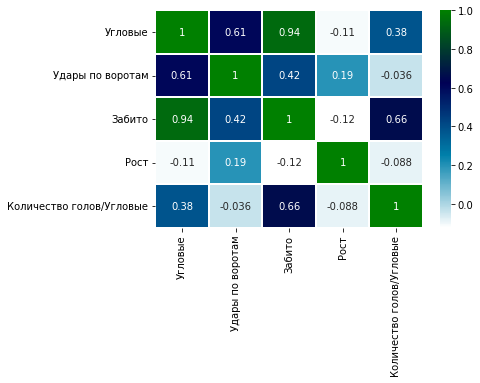

In [25]:
sns.heatmap(
    merged_df.corr(),
    annot=True,
    cmap='ocean_r',
    linewidths=0.1
);

Корреляции с ростом нет, это может как означать отсутствие зависимостей, так и просто то, что наш синтетический признак оказался плохим и мало информативным

Посмотрим на другие возможные зависимости

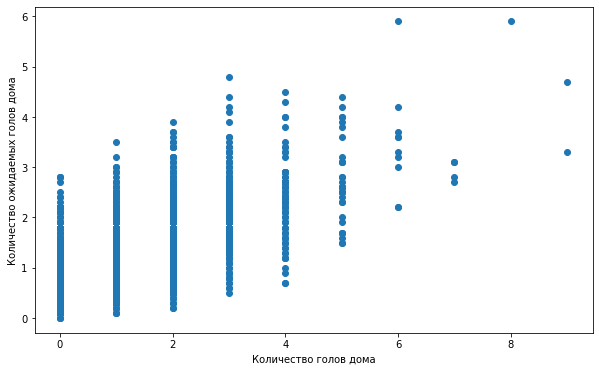

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = df['home_score'], y = df['home_xG'])
plt.xlabel("Количество голов дома")
plt.ylabel("Количество ожидаемых голов дома")

plt.show()

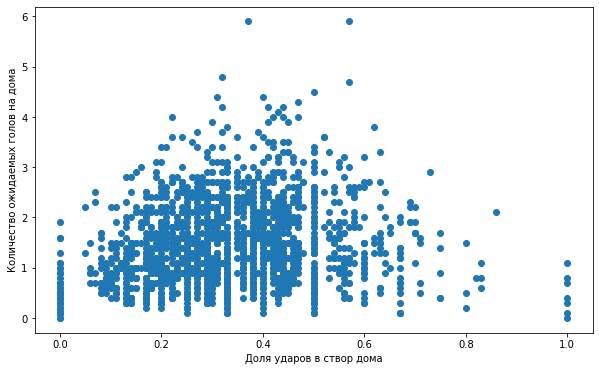

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = df['home_shots_on_target'], y = df['home_xG'])
plt.xlabel("Доля ударов в створ дома")
plt.ylabel("Количество ожидаемых голов на дома")

plt.show()

Добавим df с признаками для домашней команды

In [28]:
df_3 = df[['home_team',
 'home_score',
 'home_xG',
 'home_possession',
 'home_passing_accuracy',
 'home_shots_on_target',
 'home_yellow_cards_count',
 'home_red_cards_count',
 'home_fouls',
 'home_corners',
 'home_crosses',
 'home_touches',
 'home_tackles',
 'home_interceptions',
 'home_aerials_won',
 'home_clearances',
 'home_offsides',
 'home_goal_kicks',
 'home_throw_ins',
 'home_long_balls']]
df_3

,home_team,home_score,home_xG,home_possession,home_passing_accuracy,home_shots_on_target,home_yellow_cards_count,home_red_cards_count,home_fouls,home_corners,home_crosses,home_touches,home_tackles,home_interceptions,home_aerials_won,home_clearances,home_offsides,home_goal_kicks,home_throw_ins,home_long_balls
0,Crystal Palace,0,1.2,0.56,0.84,0.20,1,0,16,3,19,726,18,8,10,18,1,4,25,83
1,Fulham,2,1.2,0.33,0.60,0.25,2,0,7,4,19,474,24,10,23,31,4,8,22,77
2,Tottenham Hotspur,4,1.5,0.58,0.83,0.44,3,0,11,10,24,709,24,3,13,20,2,5,20,85
3,Newcastle United,2,1.7,0.61,0.79,0.39,0,0,9,11,25,634,19,11,12,14,2,2,21,64
4,Leeds United,2,0.8,0.40,0.74,0.33,2,0,13,6,20,515,21,14,9,23,0,9,16,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829,Tottenham Hotspur,2,0.6,0.55,0.81,0.27,0,0,10,7,13,702,22,9,17,17,2,5,20,58
1830,Liverpool,2,1.6,0.59,0.82,0.38,0,0,3,4,18,752,16,9,12,16,3,6,21,76
1831,Manchester United,0,1.5,0.73,0.83,0.38,3,0,9,11,17,774,15,15,19,12,3,9,23,55
1832,Fulham,0,0.7,0.67,0.88,0.13,1,0,6,5,28,901,12,13,17,7,1,6,15,66


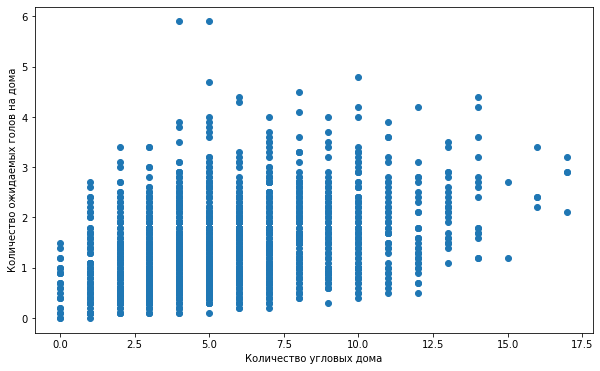

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = df['home_corners'], y = df['home_xG'])
plt.xlabel("Количество угловых дома")
plt.ylabel("Количество ожидаемых голов на дома")

plt.show()

Видно, что угловые влияют и на xG (что логично, ведь xG считает не только самы голы, но и голевые моменты)

 Построим корреляционный heatmap

<ipython-input-31-9af4d1bdf992>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_c = df_3.corr(method='pearson')


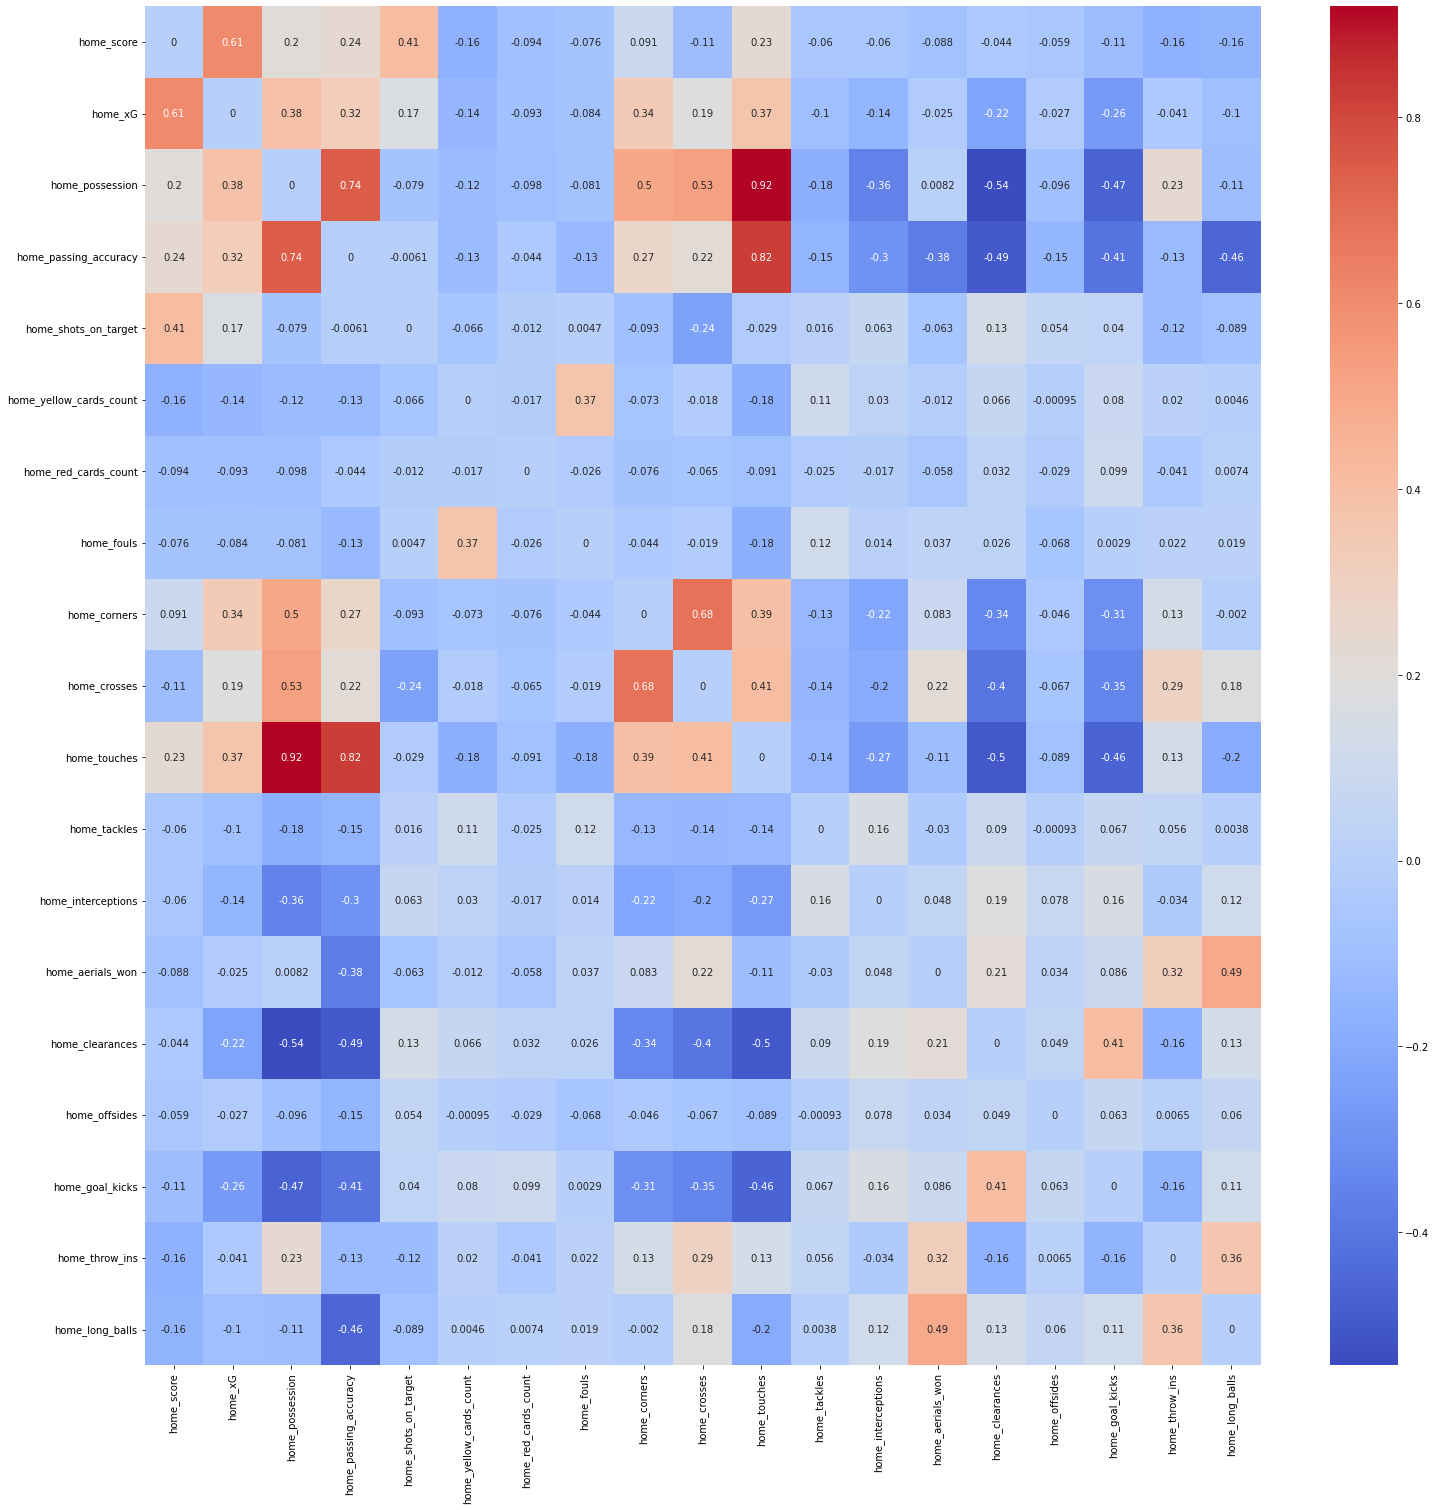

In [31]:
df_c = df_3.corr(method='pearson')
plt.figure(figsize = (25,25))
np.fill_diagonal(df_c.values, 0)
sns.heatmap(df_c, cmap='coolwarm', annot=True);

По тепловой карте выше видно, что из игровых действий команды дома лучше всего коррелирует количество касаний мяча и процент владения мячом, количество касаний и точность пасов, а также процент владения мячом и точность пасов

In [32]:
df_c.max().sort_values(ascending=False)

home_possession            0.919253
home_touches               0.919253
home_passing_accuracy      0.824886
home_crosses               0.681481
home_corners               0.681481
home_xG                    0.610529
home_score                 0.610529
home_aerials_won           0.492977
home_long_balls            0.492977
home_clearances            0.407577
home_goal_kicks            0.407577
home_shots_on_target       0.405406
home_fouls                 0.369113
home_yellow_cards_count    0.369113
home_throw_ins             0.363832
home_interceptions         0.185007
home_tackles               0.157232
home_red_cards_count       0.098522
home_offsides              0.078009
dtype: float64

Давайте посмотрим показатели Манчестер Сити, так как они сильнее выступали последние несколько сезонов

In [34]:
df_mc = df.loc[df['home_team'] == 'Manchester City']
df_mc.describe()

,home_score,home_xG,home_possession,home_passing_accuracy,home_shots_on_target,home_yellow_cards_count,home_red_cards_count,home_fouls,home_corners,home_crosses,...,guest_crosses,guest_touches,guest_tackles,guest_interceptions,guest_aerials_won,guest_clearances,guest_offsides,guest_goal_kicks,guest_throw_ins,guest_long_balls
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,...,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,2.912088,2.340659,0.669670,0.876264,0.355604,1.098901,0.021978,8.945055,8.098901,22.527473,...,9.164835,473.923077,15.384615,10.780220,10.956044,25.307692,1.956044,10.340659,13.285714,60.703297
std,1.729794,0.982285,0.081164,0.026818,0.110566,1.096002,0.147424,3.215803,3.577879,10.401219,...,4.585639,96.485259,3.915125,3.788292,5.464862,11.242471,1.645952,4.126391,4.292851,10.925500
min,0.000000,0.500000,0.470000,0.800000,0.060000,0.000000,0.000000,2.000000,1.000000,6.000000,...,1.000000,300.000000,6.000000,3.000000,2.000000,8.000000,0.000000,3.000000,3.000000,36.000000
25%,2.000000,1.600000,0.630000,0.860000,0.270000,0.000000,0.000000,6.500000,6.000000,15.500000,...,6.000000,404.000000,13.000000,8.000000,7.500000,18.000000,1.000000,8.000000,10.000000,54.000000
50%,3.000000,2.200000,0.690000,0.880000,0.350000,1.000000,0.000000,9.000000,8.000000,21.000000,...,8.000000,455.000000,15.000000,11.000000,10.000000,23.000000,2.000000,9.000000,13.000000,61.000000
75%,4.000000,2.950000,0.725000,0.890000,0.420000,2.000000,0.000000,11.000000,10.000000,28.000000,...,11.500000,534.000000,18.000000,13.500000,14.000000,31.000000,3.000000,13.000000,15.000000,68.500000
max,8.000000,5.900000,0.800000,0.920000,0.630000,5.000000,1.000000,19.000000,17.000000,62.000000,...,21.000000,782.000000,26.000000,20.000000,29.000000,80.000000,10.000000,23.000000,29.000000,81.000000


Построим таблицу с основными показателями для всех команд чемпионата

In [35]:
df_gr = df_3.groupby(['home_team']).agg('mean')
df_gr

,home_score,home_xG,home_possession,home_passing_accuracy,home_shots_on_target,home_yellow_cards_count,home_red_cards_count,home_fouls,home_corners,home_crosses,home_touches,home_tackles,home_interceptions,home_aerials_won,home_clearances,home_offsides,home_goal_kicks,home_throw_ins,home_long_balls
home_team,,,,,,,,,,,,,,,,,,,
Arsenal,1.978261,1.720652,0.575870,0.816196,0.348913,1.684783,0.021739,10.456522,6.619565,20.076087,679.434783,14.750000,8.673913,13.456522,16.336957,2.054348,5.836957,18.619565,59.652174
Aston Villa,1.486111,1.380556,0.478889,0.766250,0.350139,1.750000,0.013889,11.194444,5.388889,20.055556,556.319444,14.944444,9.152778,16.305556,19.597222,1.458333,7.041667,19.555556,65.652778
Bournemouth,1.240741,1.288889,0.442222,0.736667,0.302963,1.907407,0.018519,9.925926,4.962963,16.240741,549.814815,14.314815,10.611111,18.203704,26.185185,1.629630,8.148148,21.777778,64.518519
Brentford,1.485714,1.497143,0.438857,0.694857,0.339429,1.571429,0.028571,9.514286,4.714286,18.828571,525.942857,16.771429,10.057143,19.200000,20.942857,1.542857,7.057143,20.942857,75.600000
Brighton & Hove Albion,1.166667,1.412222,0.529444,0.784444,0.278111,1.588889,0.044444,11.044444,6.044444,20.544444,636.000000,16.766667,10.400000,16.188889,15.722222,1.888889,6.133333,21.811111,69.122222
Burnley,1.052632,1.309211,0.431842,0.686842,0.311974,1.592105,0.000000,10.302632,4.855263,21.710526,517.157895,14.736842,10.381579,23.552632,21.684211,2.657895,6.960526,22.605263,87.171053
Cardiff City,1.105263,1.289474,0.367895,0.603158,0.291579,1.736842,0.000000,10.263158,5.000000,17.000000,430.157895,16.736842,13.263158,27.315789,24.526316,2.526316,7.052632,20.578947,86.000000
Chelsea,1.673913,1.751087,0.608370,0.841304,0.344022,1.532609,0.010870,10.141304,6.630435,20.467391,766.619565,17.565217,9.489130,15.108696,15.597826,1.956522,6.413043,20.076087,59.576087
Crystal Palace,1.032609,1.154348,0.463913,0.747174,0.302826,1.673913,0.032609,10.847826,5.239130,17.456522,574.445652,18.054348,10.771739,17.858696,20.728261,1.793478,7.195652,23.260870,70.239130


Отсортируем их по голам

In [36]:
df_gr.sort_values(by='home_score', ascending=False)

,home_score,home_xG,home_possession,home_passing_accuracy,home_shots_on_target,home_yellow_cards_count,home_red_cards_count,home_fouls,home_corners,home_crosses,home_touches,home_tackles,home_interceptions,home_aerials_won,home_clearances,home_offsides,home_goal_kicks,home_throw_ins,home_long_balls
home_team,,,,,,,,,,,,,,,,,,,
Manchester City,2.912088,2.340659,0.669670,0.876264,0.355604,1.098901,0.021978,8.945055,8.098901,22.527473,834.813187,12.571429,8.043956,12.626374,10.736264,1.670330,3.813187,17.890110,57.516484
Liverpool,2.461538,2.149451,0.631758,0.827582,0.356264,0.989011,0.021978,9.076923,7.318681,23.791209,800.263736,15.318681,9.087912,14.307692,14.054945,1.736264,5.483516,22.010989,72.230769
Arsenal,1.978261,1.720652,0.575870,0.816196,0.348913,1.684783,0.021739,10.456522,6.619565,20.076087,679.434783,14.750000,8.673913,13.456522,16.336957,2.054348,5.836957,18.619565,59.652174
Tottenham Hotspur,1.913043,1.586957,0.537065,0.810543,0.367174,1.739130,0.010870,11.130435,5.402174,17.847826,673.750000,16.054348,8.989130,15.978261,19.369565,1.673913,6.565217,19.402174,62.228261
Manchester United,1.868132,1.707692,0.555275,0.811099,0.380330,1.714286,0.054945,10.714286,5.637363,17.538462,682.769231,15.043956,9.461538,14.659341,17.692308,2.164835,6.681319,20.406593,61.428571
Chelsea,1.673913,1.751087,0.608370,0.841304,0.344022,1.532609,0.010870,10.141304,6.630435,20.467391,766.619565,17.565217,9.489130,15.108696,15.597826,1.956522,6.413043,20.076087,59.576087
West Ham United,1.608696,1.368478,0.457717,0.753696,0.348261,1.434783,0.010870,9.326087,5.260870,20.826087,565.967391,16.304348,10.521739,18.880435,19.532609,1.902174,6.663043,20.836957,69.065217
Leicester City,1.586957,1.364130,0.536304,0.793478,0.347283,1.347826,0.021739,10.380435,5.304348,17.619565,660.739130,18.521739,10.836957,16.010870,19.402174,1.836957,6.358696,21.228261,62.076087
Aston Villa,1.486111,1.380556,0.478889,0.766250,0.350139,1.750000,0.013889,11.194444,5.388889,20.055556,556.319444,14.944444,9.152778,16.305556,19.597222,1.458333,7.041667,19.555556,65.652778


А теперь по xG

In [37]:
df_gr.sort_values(by='home_xG', ascending=False)

,home_score,home_xG,home_possession,home_passing_accuracy,home_shots_on_target,home_yellow_cards_count,home_red_cards_count,home_fouls,home_corners,home_crosses,home_touches,home_tackles,home_interceptions,home_aerials_won,home_clearances,home_offsides,home_goal_kicks,home_throw_ins,home_long_balls
home_team,,,,,,,,,,,,,,,,,,,
Manchester City,2.912088,2.340659,0.669670,0.876264,0.355604,1.098901,0.021978,8.945055,8.098901,22.527473,834.813187,12.571429,8.043956,12.626374,10.736264,1.670330,3.813187,17.890110,57.516484
Liverpool,2.461538,2.149451,0.631758,0.827582,0.356264,0.989011,0.021978,9.076923,7.318681,23.791209,800.263736,15.318681,9.087912,14.307692,14.054945,1.736264,5.483516,22.010989,72.230769
Chelsea,1.673913,1.751087,0.608370,0.841304,0.344022,1.532609,0.010870,10.141304,6.630435,20.467391,766.619565,17.565217,9.489130,15.108696,15.597826,1.956522,6.413043,20.076087,59.576087
Arsenal,1.978261,1.720652,0.575870,0.816196,0.348913,1.684783,0.021739,10.456522,6.619565,20.076087,679.434783,14.750000,8.673913,13.456522,16.336957,2.054348,5.836957,18.619565,59.652174
Manchester United,1.868132,1.707692,0.555275,0.811099,0.380330,1.714286,0.054945,10.714286,5.637363,17.538462,682.769231,15.043956,9.461538,14.659341,17.692308,2.164835,6.681319,20.406593,61.428571
Tottenham Hotspur,1.913043,1.586957,0.537065,0.810543,0.367174,1.739130,0.010870,11.130435,5.402174,17.847826,673.750000,16.054348,8.989130,15.978261,19.369565,1.673913,6.565217,19.402174,62.228261
Brentford,1.485714,1.497143,0.438857,0.694857,0.339429,1.571429,0.028571,9.514286,4.714286,18.828571,525.942857,16.771429,10.057143,19.200000,20.942857,1.542857,7.057143,20.942857,75.600000
Brighton & Hove Albion,1.166667,1.412222,0.529444,0.784444,0.278111,1.588889,0.044444,11.044444,6.044444,20.544444,636.000000,16.766667,10.400000,16.188889,15.722222,1.888889,6.133333,21.811111,69.122222
Leeds United,1.277778,1.411111,0.539630,0.769259,0.335741,2.148148,0.037037,12.037037,5.703704,20.222222,620.777778,19.592593,10.555556,13.370370,16.129630,1.777778,6.703704,20.555556,60.851852


Так же посмотрим на команды с самыми высокими значениями владения мяча и точности пасов

In [38]:
df_gr.sort_values(by='home_possession', ascending=False)

,home_score,home_xG,home_possession,home_passing_accuracy,home_shots_on_target,home_yellow_cards_count,home_red_cards_count,home_fouls,home_corners,home_crosses,home_touches,home_tackles,home_interceptions,home_aerials_won,home_clearances,home_offsides,home_goal_kicks,home_throw_ins,home_long_balls
home_team,,,,,,,,,,,,,,,,,,,
Manchester City,2.912088,2.340659,0.669670,0.876264,0.355604,1.098901,0.021978,8.945055,8.098901,22.527473,834.813187,12.571429,8.043956,12.626374,10.736264,1.670330,3.813187,17.890110,57.516484
Liverpool,2.461538,2.149451,0.631758,0.827582,0.356264,0.989011,0.021978,9.076923,7.318681,23.791209,800.263736,15.318681,9.087912,14.307692,14.054945,1.736264,5.483516,22.010989,72.230769
Chelsea,1.673913,1.751087,0.608370,0.841304,0.344022,1.532609,0.010870,10.141304,6.630435,20.467391,766.619565,17.565217,9.489130,15.108696,15.597826,1.956522,6.413043,20.076087,59.576087
Arsenal,1.978261,1.720652,0.575870,0.816196,0.348913,1.684783,0.021739,10.456522,6.619565,20.076087,679.434783,14.750000,8.673913,13.456522,16.336957,2.054348,5.836957,18.619565,59.652174
Manchester United,1.868132,1.707692,0.555275,0.811099,0.380330,1.714286,0.054945,10.714286,5.637363,17.538462,682.769231,15.043956,9.461538,14.659341,17.692308,2.164835,6.681319,20.406593,61.428571
Leeds United,1.277778,1.411111,0.539630,0.769259,0.335741,2.148148,0.037037,12.037037,5.703704,20.222222,620.777778,19.592593,10.555556,13.370370,16.129630,1.777778,6.703704,20.555556,60.851852
Tottenham Hotspur,1.913043,1.586957,0.537065,0.810543,0.367174,1.739130,0.010870,11.130435,5.402174,17.847826,673.750000,16.054348,8.989130,15.978261,19.369565,1.673913,6.565217,19.402174,62.228261
Leicester City,1.586957,1.364130,0.536304,0.793478,0.347283,1.347826,0.021739,10.380435,5.304348,17.619565,660.739130,18.521739,10.836957,16.010870,19.402174,1.836957,6.358696,21.228261,62.076087
Brighton & Hove Albion,1.166667,1.412222,0.529444,0.784444,0.278111,1.588889,0.044444,11.044444,6.044444,20.544444,636.000000,16.766667,10.400000,16.188889,15.722222,1.888889,6.133333,21.811111,69.122222


In [39]:
df_gr.sort_values(by='home_shots_on_target', ascending=False)

,home_score,home_xG,home_possession,home_passing_accuracy,home_shots_on_target,home_yellow_cards_count,home_red_cards_count,home_fouls,home_corners,home_crosses,home_touches,home_tackles,home_interceptions,home_aerials_won,home_clearances,home_offsides,home_goal_kicks,home_throw_ins,home_long_balls
home_team,,,,,,,,,,,,,,,,,,,
Manchester United,1.868132,1.707692,0.555275,0.811099,0.380330,1.714286,0.054945,10.714286,5.637363,17.538462,682.769231,15.043956,9.461538,14.659341,17.692308,2.164835,6.681319,20.406593,61.428571
Tottenham Hotspur,1.913043,1.586957,0.537065,0.810543,0.367174,1.739130,0.010870,11.130435,5.402174,17.847826,673.750000,16.054348,8.989130,15.978261,19.369565,1.673913,6.565217,19.402174,62.228261
West Bromwich Albion,0.789474,0.973684,0.387895,0.682105,0.366316,1.368421,0.105263,10.789474,5.210526,18.894737,483.789474,13.105263,12.368421,20.736842,22.789474,1.842105,7.631579,18.947368,79.210526
Liverpool,2.461538,2.149451,0.631758,0.827582,0.356264,0.989011,0.021978,9.076923,7.318681,23.791209,800.263736,15.318681,9.087912,14.307692,14.054945,1.736264,5.483516,22.010989,72.230769
Manchester City,2.912088,2.340659,0.669670,0.876264,0.355604,1.098901,0.021978,8.945055,8.098901,22.527473,834.813187,12.571429,8.043956,12.626374,10.736264,1.670330,3.813187,17.890110,57.516484
Southampton,1.239130,1.205435,0.472065,0.730109,0.354348,1.543478,0.054348,11.032609,5.271739,17.934783,574.173913,17.956522,11.923913,17.750000,21.739130,1.608696,6.456522,21.880435,68.652174
Aston Villa,1.486111,1.380556,0.478889,0.766250,0.350139,1.750000,0.013889,11.194444,5.388889,20.055556,556.319444,14.944444,9.152778,16.305556,19.597222,1.458333,7.041667,19.555556,65.652778
Arsenal,1.978261,1.720652,0.575870,0.816196,0.348913,1.684783,0.021739,10.456522,6.619565,20.076087,679.434783,14.750000,8.673913,13.456522,16.336957,2.054348,5.836957,18.619565,59.652174
West Ham United,1.608696,1.368478,0.457717,0.753696,0.348261,1.434783,0.010870,9.326087,5.260870,20.826087,565.967391,16.304348,10.521739,18.880435,19.532609,1.902174,6.663043,20.836957,69.065217


По отсортированным табличкам можно сделать некоторые выводы: по количеству голов дома, ожидаемым голам дома и домашнему владению мячом уверенно лидирует Манчестер Сити, который в последние несколько лет почти безоговорочно является сильнейшим клубом АПЛ. Также видно, что первые 4 или 5 команд, лидирующих по этим показателям, почти не меняются - Манчестер Сити, Ливерпуль, Челси и Арсенал чаще других находятся в этих топах. Интересно также, что МС всего-лишь пятый по проценту ударов в створ дома, но выступает значительно сильнее, чем Манчестер Юнайтед, находящийся на 1 месте по этому показателю.

## Шаг 5. Создание новых признаков

## Шаг 6. Гипотезы

Так как мы собрали довольно много разной статистики, есть смысл поискать в ней какие-то иные взаимосвязи помимо корреляций и оформить это в виде тестирования гипотез. Ранее мы уже видели, как коррелируют разные футбольные показатели: количество ударов с количеством голов, количество фолов с количеством отборов и т.д. . Например, интересно было бы посмотреть на то, сможет ли команда статистически забить еще один гол, если подаст на 5 угловых больше, чем подала на самом деле? Подобные вопросы можно сформулировать применительно практически ко всем рассматриваемым нами показателям. Можно проверить, совершает ли команда больше фолов зимой и весной, когда в Англии дождливо и пасмурно, чем летом или ранней осенью, когда погода солнечная и газон на стадионе сухой. Такие гипотезы заканчиваются там, где заканчивается фантазия того, кто их проверяет. Мы протестируем несколько таких гипотез и посмотрим, как можно будет проинтерпретировать результаты наших тестов.

1) Проверим гипотезу о погодных условиях, для этого:
- проведем корреляционный анализ между погодными условиями и результатами матчей;
- проведем t-тестирование, чтобы определить, есть ли разница в результатах матчей в зависимости от погодных условий;
- проведем регрессионный анализ, чтобы определить, какие погодные условия оказывают наибольшее влияние на результаты матчей.


__Нулевая гипотеза: В результатах матчей существуют различия в зависимости от погодных условий.__
$$
\begin{aligned}
& H_0: \mu_{cold} \neq \mu_{hot} \\
& H_1: \mu_{cold} = \mu_{hot}
\end{aligned}
$$

In [7]:
scores = data[['home_score', 'guest_score', 'Дневная температура', 'Дождь', 'Осадки']]
corr_matrix = scores.corr()
print(corr_matrix)

                     home_score  guest_score  Дневная температура     Дождь  \
home_score             1.000000    -0.136649             0.097954  0.175414   
guest_score           -0.136649     1.000000            -0.020499 -0.049175   
Дневная температура    0.097954    -0.020499             1.000000  0.086736   
Дождь                  0.175414    -0.049175             0.086736  1.000000   
Осадки                 0.187232    -0.083980             0.142399  0.706890   

                       Осадки  
home_score           0.187232  
guest_score         -0.083980  
Дневная температура  0.142399  
Дождь                0.706890  
Осадки               1.000000  


In [8]:
data['Дневная температура'] = data['Дневная температура'].str.replace('+', '')
hot = data[data['Дневная температура'].astype(float) > data['Дневная температура'].astype(float).mean()]
cold = data[data['Дневная температура'].astype(float) <= data['Дневная температура'].astype(float).mean()]

# Проводим t-тест для групп матчей c разной температурой
# Уровень значимости: 0.05
alpha = 0.05
t_stat, p_val = ttest_ind(hot['home_score'], cold['home_score'])

print('t-статистика:', t_stat)
print('значение p:', p_val)

if p_val < alpha:
    print('Нулевая гипотеза не отвергается: в результатах матчей существуют различия в зависимости от погодных условий')
else:
    print('Нулевая гипотеза отвергается: в результатах матчей нет существенных различий в зависимости от погодных условий')


t-статистика: 1.7894360648774648
значение p: 0.07394374292824933
Нулевая гипотеза отвергается: в результатах матчей нет существенных различий в зависимости от погодных условий


In [9]:
scores['Дневная_температура'] = scores['Дневная температура']
regression = ols('home_score ~ Дневная_температура + Дождь + Осадки', data=scores).fit()
print(regression.summary())

                            OLS Regression Results                            
Dep. Variable:             home_score   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     1.228
Date:                Wed, 14 Jun 2023   Prob (F-statistic):             0.0475
Time:                        23:11:45   Log-Likelihood:                -1214.8
No. Observations:                 760   AIC:                             2744.
Df Residuals:                     603   BIC:                             3471.
Df Model:                         156                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

/var/folders/zs/qsj7l81d767f5zkrl6sbh5bh0000gn/T/ipykernel_18149/3642463506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores['Дневная_температура'] = scores['Дневная температура']


2) Проверим гипотезу о росте игроков, для этого:
- посчитаем коэффициент корреляции Пирсона;
- проведем t-тестирование, чтобы определить, есть ли разница в количестве забитых голов в зависимости от роста игроков;
- проведем регрессионный анализ, чтобы определить, как рост влияет на успех команды.


__Нулевая гипотеза: Команды со средним ростом ниже забивают чаще.__
$$
\begin{aligned}
& H_0: \mu_{high} > \mu_{low} \\
& H_1: \mu_{high} = \mu_{low}
\end{aligned}
$$

In [30]:
corr_1, p_val_1 = pearsonr(merged_df['Рост'], merged_df['Угловые'])
corr_2, p_val_2 = pearsonr(merged_df['Рост'], merged_df['Забито'])
# Уровень значимости: 0.05
alpha = 0.05

if p_val_1 < alpha:
    print('Связь между средним ростом игроков и количеством угловых ударов имеется')
else:
    print('Связи нет')
if p_val_2 < alpha:
    print('Связь между средним ростом игроков и количеством угловых ударов имеется')
else:
    print('Связи нет, можно предположить, что игроки с меньшим средним ростом чаще забивают')

Связи нет
Связи нет, можно предположить, что игроки с меньшим средним ростом чаще забивают


In [31]:
high_height = merged_df[merged_df['Рост'].astype(float) > merged_df['Рост'].astype(float).mean()]
low_height = merged_df[merged_df['Рост'].astype(float) <= merged_df['Рост'].astype(float).mean()]

# Проводим t-тест для групп матчей c разной температурой
# Уровень значимости: 0.05
alpha = 0.05
t_stat, p_val = ttest_ind(low_height['Забито'],high_height['Забито'])

print('t-статистика:', t_stat)
print('значение p:', p_val)

if p_val < alpha:
    print('Нулевая гипотеза не отвергается: команды со средним ростом ниже забивают чаще')
else:
    print('Нулевая гипотеза отвергается: значимого различия нет')

t-статистика: 0.46459310813414584
значение p: 0.6477932246745144
Нулевая гипотеза отвергается: значимого различия нет


In [32]:
regression = ols('Забито ~ Рост', data = merged_df).fit()
print(regression.summary())

                            OLS Regression Results                            
Dep. Variable:                 Забито   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.043
Method:                 Least Squares   F-statistic:                    0.2108
Date:                Wed, 14 Jun 2023   Prob (F-statistic):              0.652
Time:                        23:23:38   Log-Likelihood:                -125.77
No. Observations:                  20   AIC:                             255.5
Df Residuals:                      18   BIC:                             257.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2446.2437   4737.827      0.516      0.6

Посмотрим некоторые гипотезы, связанные с введением VAR в АПЛ в сезоне 2019-2020

In [14]:
import json
import pandas as pd

with open("match_stats.json", "r") as f:
    x = json.load(f)    
df = pd.DataFrame.from_dict(pd.json_normalize(x), orient='columns')
df.loc[df['match_date'] == '2018-08-10'] #первый матч сезона 2018/2019 был на 1454 строчке

df_var = df[:1454]
df_var

,match_date,match_week,home.team,home.score,home.xG,home.possession,home.passing_accuracy,home.shots_on_target,home.yellow_cards_count,home.red_cards_count,...,guest.crosses,guest.touches,guest.tackles,guest.interceptions,guest.aerials_won,guest.clearances,guest.offsides,guest.goal_kicks,guest.throw_ins,guest.long_balls
0,2022-08-05,1,Crystal Palace,0,1.2,0.56,0.84,0.20,1,0,...,11,599,29,9,14,24,2,2,14,59
1,2022-08-06,1,Fulham,2,1.2,0.33,0.60,0.25,2,0,...,18,784,11,10,13,16,4,5,35,94
2,2022-08-06,1,Tottenham Hotspur,4,1.5,0.58,0.83,0.44,3,0,...,18,554,14,13,11,21,0,4,14,61
3,2022-08-06,1,Newcastle United,2,1.7,0.61,0.79,0.39,0,0,...,9,475,15,10,16,37,0,12,26,70
4,2022-08-06,1,Leeds United,2,0.8,0.40,0.74,0.33,2,0,...,20,720,16,14,7,17,1,9,23,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,2020-07-26,38,Manchester City,5,3.2,0.73,0.90,0.29,1,0,...,3,390,14,14,7,27,2,23,13,67
1450,2020-07-26,38,Chelsea,2,1.4,0.62,0.82,0.27,2,0,...,9,523,22,8,24,7,1,7,29,78
1451,2020-07-26,38,West Ham United,1,0.9,0.62,0.81,0.10,2,0,...,14,415,13,10,14,12,1,8,29,79
1452,2020-07-26,38,Newcastle United,1,0.1,0.26,0.65,0.67,1,0,...,17,949,12,8,17,10,1,2,30,74


In [15]:
df_no_var = df[1454:]
df_no_var

,match_date,match_week,home.team,home.score,home.xG,home.possession,home.passing_accuracy,home.shots_on_target,home.yellow_cards_count,home.red_cards_count,...,guest.crosses,guest.touches,guest.tackles,guest.interceptions,guest.aerials_won,guest.clearances,guest.offsides,guest.goal_kicks,guest.throw_ins,guest.long_balls
1454,2018-08-10,1,Manchester United,2,1.5,0.47,0.80,0.71,2,0,...,27,702,14,12,13,14,2,4,18,65
1455,2018-08-11,1,Newcastle United,1,1.0,0.42,0.68,0.13,2,0,...,17,776,27,10,21,43,0,10,24,80
1456,2018-08-11,1,Fulham,0,0.7,0.65,0.85,0.40,1,0,...,12,514,22,14,20,32,3,8,25,67
1457,2018-08-11,1,Bournemouth,2,2.2,0.63,0.79,0.27,1,0,...,18,456,22,15,31,31,2,10,20,98
1458,2018-08-11,1,Watford,2,1.2,0.53,0.73,0.26,2,0,...,15,537,16,17,24,26,3,10,19,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829,2019-05-12,38,Tottenham Hotspur,2,0.6,0.55,0.81,0.27,0,0,...,18,599,16,11,18,20,1,8,17,61
1830,2019-05-12,38,Liverpool,2,1.6,0.59,0.82,0.38,0,0,...,7,562,14,9,17,21,1,9,19,84
1831,2019-05-12,38,Manchester United,0,1.5,0.73,0.83,0.38,3,0,...,5,371,16,15,14,24,0,14,22,81
1832,2019-05-12,38,Fulham,0,0.7,0.67,0.88,0.13,1,0,...,9,509,15,12,12,40,1,12,17,69


Как мы знаем, в АПЛ система VAR была внедрена в работу с сезона 2019/2020. Разделим наш датафрейм на две части: до сезона 2019/2020 без VAR и после него, когда VAR начал помогать арбитрам

In [16]:
df_var[['home.score', 'guest.score']]

a = df_var['home.score']
b = df_var['guest.score']

total_data = a + b

total_data

0       2
1       4
2       5
3       2
4       3
       ..
1449    5
1450    2
1451    2
1452    4
1453    3
Length: 1454, dtype: int64

In [17]:
df_no_var[['home.score', 'guest.score']].sum().sum() / len(df_no_var)

2.8210526315789473

Проверим гипотезу о том, что среднее количество забитых голов до var такое же, как и после введения var

In [18]:
import scipy.stats as sts

sts.ttest_1samp(a=total_data, popmean=2.75)

Ttest_1sampResult(statistic=0.11823707311950689, pvalue=0.905896158576827)

Мы видим, что pvalue равно примерно 0.9, значит наша гипотеза о том, что среднее количество забитых голов до и после введения var не отвергается на любом разумном уровне значимости

Как мы знаем, var рассматривает только значимые эпизоды матча, которые непосредственно влияют на игру: голы, возможная красная карточка какому-либо игроку, или назначать/не назначать пенальти. Гипотезу с голами мы уже проверили, проверим и с красными карточками

In [19]:
df_var[['home.red_cards_count','guest.red_cards_count']]

c = df_var['home.score']
d = df_var['guest.score']

red_cards_data = a + b
red_cards_data

0       2
1       4
2       5
3       2
4       3
       ..
1449    5
1450    2
1451    2
1452    4
1453    3
Length: 1454, dtype: int64

In [20]:
red_cards_before = df_no_var[['home.red_cards_count','guest.red_cards_count']].sum().sum() / len(df_no_var)
red_cards_before

0.07631578947368421

In [21]:
sts.ttest_1samp(a=red_cards_data, popmean=red_cards_before)

Ttest_1sampResult(statistic=61.40503412042225, pvalue=0.0)

p-value в этой ситуации оказался равен 0, значит можно сделать вывод, что гипотеза о равенстве среднего количества красных карточек до введения var и после отвергается на любом разумном уровне значимости

## Шаг 7. Машинное обучение

**Описание, как мы собираемся это делать**

Так как почти все наши признаки известны лишь после матча, предсказывать результат напрямую по ним не выйдет. Наша идея состоит в том, чтобы агрегировать признаки каждой команды за последние n матчей.
n будет гиперпараметром, который вероятно придётся подбирать, так как сразу сказать, сколько матчей брать — сложно. Если взять очень маленький период, то фактор везения или случайности будет слишком сильно влиять на результат, а если очень большой, то какие-то данные могут быть устаревшими (со временем в команде может меняться тактика, тренер, состав и многое другое, что серьёзно влияет на её результативность).

Имея агрегированные данные двух команд мы собираемся посчитать разницу (или отношение) между ними и на основе этого обучить логистическую регрессию для предсказания вероятности победы домашней команды. Далее мы подберем пороги вероятностей для определения победы, ничьи и поражения.

Возможно, если качество модели логистической регрессии будет низкое, мы попробуем другие модели для задачи многоклассовой классификации (например, деревья или бустинг), но пока это в наши планы не входит.